# Testing

In [1]:
import sys, os
sys.path.append("../../")
sys.path.append("../../../")
sys.path.append("../../../../")
import setting
from sklearn.metrics import classification_report
from Clust.clust.ML.common.common import p1_integratedDataSaving as p1
from Clust.clust.ML.tool import data as ml_data
from Clust.clust.ML.tool import scaler as ml_scaler
import pathSetting

import torch
#import main_regression as mr
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


## Test Data Preparation

In [2]:
# 1 (p2부분 1. Data Selection)
data_meta = p1.read_json_data(pathSetting.DataMetaPath)
dataList =  list(data_meta.keys())

In [3]:
dataList

['trainX_ActionPatternData',
 'trainy_ActionPatternData',
 'testX_ActionPatternData',
 'testy_ActionPatternData']

In [4]:
# 1. Select Test Data
# dataX
data_name_X = dataList[2]
# datay
data_name_y = dataList[3]
data_folder_name = "data_integrated_result"

# 2. select Model 
# ModelMeta =p1.read_json_data(pathSetting.trainModelMetaFilePath)
# modelList = list(ModelMeta.keys())
# modelName = modelList[2]

window_num=128

### Get model meta by mongodb

In [5]:
from Clust.clust.ingestion.mongo import mongo_client 
from Clust.setting import influx_setting_KETI as ins

mongo_client = mongo_client.MongoClient(ins.CLUSTMetaInfo2)

db_name = 'model'
collection_name = 'meta'

all_model_meta = mongo_client.get_all_document(db_name, collection_name)

In [6]:
all_model_meta

[{'author': 'KETI',
  'modelName': 'EnergyLSTMRegression',
  'modelVersion': 0.1,
  'trainDataInfo': {'startTime': '2016-01-11',
   'endTime': '2016-04-15',
   'dataInfo': [['life_indoor_environment', 'humidityTrain_10min'],
    ['life_indoor_environment', 'temperatureTrain_10min'],
    ['weather_outdoor_environment', 'belgiumChieverseAirportTrain_10min']],
   'processParam': {'refine_param': {'removeDuplication': {'flag': False},
     'staticFrequency': {'flag': False, 'frequency': None}},
    'outlier_param': {'certainErrorToNaN': {'flag': False},
     'unCertainErrorToNaN': {'flag': False, 'param': {}}},
    'imputation_param': {'flag': False,
     'imputation_method': [],
     'totalNonNanRatio': 80}},
   'integration_freq_sec': 600,
   'cleanParam': 'NoClean',
   'DataSaveMode': 'CSV'},
  'featureList': ['RH_1',
   'RH_2',
   'RH_3',
   'RH_4',
   'RH_5',
   'RH_6',
   'RH_7',
   'RH_8',
   'RH_9',
   'T1',
   'T2',
   'T3',
   'T4',
   'T5',
   'T6',
   'T7',
   'T8',
   'T9',
  

In [7]:
search = {'modelName': 'New_ClassificationNocleanLSTM_cf'}
model_meta= mongo_client.get_document_by_json(db_name, collection_name, search)
model_meta = model_meta[0]

In [8]:
model_meta

{'author': 'KETI',
 'modelName': 'New_ClassificationNocleanLSTM_cf',
 'modelVersion': 0.1,
 'trainDataInfo': {'startTime': '1992-1-11',
  'endTime': '2012-02-27',
  'dataInfo': [['bio_action_sensors', 'accelerationTrain']],
  'processParam': {'refine_param': {'removeDuplication': {'flag': False},
    'staticFrequency': {'flag': False, 'frequency': None}},
   'outlier_param': {'certainErrorToNaN': {'flag': False},
    'unCertainErrorToNaN': {'flag': False, 'param': {}}},
   'imputation_param': {'flag': False,
    'imputation_method': [],
    'totalNonNanRatio': 80}},
  'integration_freq_sec': 675,
  'cleanParam': 'NoClean',
  'DataSaveMode': 'CSV'},
 'featureList': ['col_0',
  'col_1',
  'col_2',
  'col_3',
  'col_4',
  'col_5',
  'col_6',
  'col_7',
  'col_8'],
 'target': ['value'],
 'trainDataType': 'timeseries',
 'modelPurpose': 'classification',
 'model_method': 'LSTM_cf',
 'modelTags': ['action', 'sensor', 'classification', 'pattern'],
 'cleanTrainDataParam': 'NoClean',
 'NaNProces

## Testing

In [9]:
data_save_mode_X = data_meta[data_name_X]["integrationInfo"]["DataSaveMode"]
data_save_mode_y = data_meta[data_name_y]["integrationInfo"]["DataSaveMode"]
data_X = ml_data.get_saved_integrated_data(data_save_mode_X, data_name_X, data_folder_name)
data_y = ml_data.get_saved_integrated_data(data_save_mode_y, data_name_y, data_folder_name)

X_scaler_file_path = model_meta['files']['XScalerFile']["filePath"]
y_scaler_file_path = model_meta['files']['yScalerFile']["filePath"]
model_file_path = model_meta['files']['modelFile']["filePath"]

feature_list = model_meta["featureList"]
target = model_meta["target"]
scaler_param = model_meta["scalerParam"]
model_method = model_meta["model_method"]
train_parameter = model_meta["trainParameter"]

dim = None
if model_method == "FC_cf":
    dim = 2

test_X, scaler_X = ml_scaler.get_scaled_test_data(data_X[feature_list], X_scaler_file_path, scaler_param)
test_y, scaler_y = ml_scaler.get_scaled_test_data(data_y[target], y_scaler_file_path, scaler_param)# No Scale

# test_y = datay[target] # for classification

# 4. Testing
batch_size=1
train_parameter['batch_size'] = 1
scaler_param="noScale" # for classification

In [10]:
from Clust.clust.ML.classification.test import ClassificationTest

CTest = ClassificationTest()
CTest.set_param(train_parameter)
CTest.set_model(model_method, model_file_path)
CTest.set_data(test_X, test_y, window_num, dim)
preds, probs, trues, acc = CTest.test()


Start testing data

** Performance of test dataset ==> PROB = [[0.22609955 0.17416899 0.14374095 0.154954   0.26256883 0.03846779]
 [0.03204642 0.02761276 0.02061742 0.23507743 0.031447   0.653199  ]
 [0.22559246 0.17369302 0.14198473 0.15672624 0.26524442 0.03675913]
 ...
 [0.22191754 0.16965659 0.13764122 0.1718708  0.25985223 0.03906169]
 [0.2232452  0.1711439  0.13952838 0.16631225 0.2611227  0.03864749]
 [0.02939655 0.02503793 0.0199069  0.20787512 0.02733691 0.69044656]], ACC = 0.3328519855595668
** Dimension of result for test dataset = (1385,)


In [12]:
result_metrics = classification_report(trues, preds, output_dict = True)
df_result = ml_data.get_prediction_df_result(preds, trues, scaler_param, scaler_y, feature_list= target, target_col = target[0])

noScale


/home/leezy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leezy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leezy/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# df_result, result_metrics_df, acc= app.get_test_result(dataName_X, dataName_y, DataMeta, model_meta, dataFolderName, windowNum, pathSetting.db_client)

In [14]:
df_result

,value,prediction
0,0,4
1,3,5
2,2,4
3,3,4
4,4,4
...,...,...
1380,3,4
1381,0,4
1382,4,4
1383,4,4


{3, 4, 5}

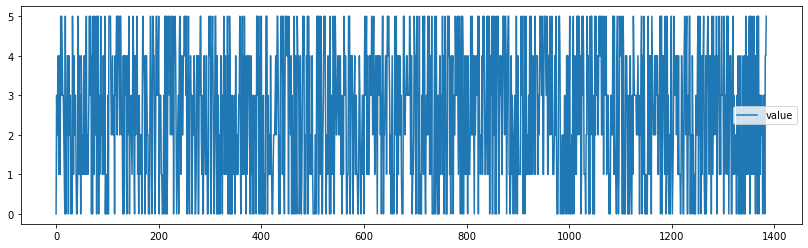

In [15]:
df_result[['value']].plot()

set(df_result['prediction'].values)

<AxesSubplot:>

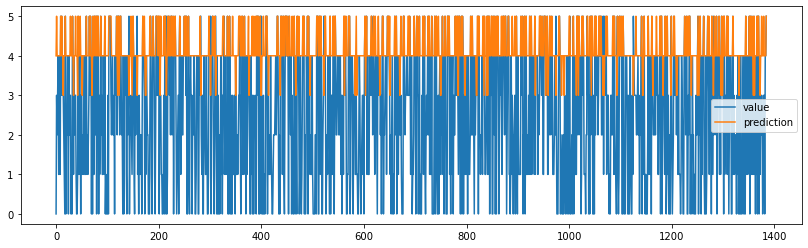

In [16]:
df_result.plot()

In [19]:
result_metrics

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 251},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 223},
 '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 197},
 '3': {'precision': 0.1506849315068493,
  'recall': 0.04824561403508772,
  'f1-score': 0.07308970099667775,
  'support': 228},
 '4': {'precision': 0.22439024390243903,
  'recall': 0.9236947791164659,
  'f1-score': 0.36106750392464676,
  'support': 249},
 '5': {'precision': 0.7665505226480837,
  'recall': 0.9282700421940928,
  'f1-score': 0.8396946564885496,
  'support': 237},
 'accuracy': 0.3328519855595668,
 'macro avg': {'precision': 0.19027094967622868,
  'recall': 0.3167017392242744,
  'f1-score': 0.21230864356831236,
  'support': 1385},
 'weighted avg': {'precision': 0.196318995655498,
  'recall': 0.3328519855595668,
  'f1-score': 0.2206338584059681,
  'support': 1385}}

In [20]:
acc

0.3328519855595668